## Autoregressive Image Modeling - Exercise 4.
### Daniel Aibinder 318239639, Yonathan Dovgolevsky 327709648

In [1]:
## Standard libraries
import os
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

C:\Users\Danny\AppData\Local\Temp\ipykernel_22564\1202862137.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Using device cuda:0


<Figure size 640x480 with 0 Axes>

In [2]:
# Convert images from 0-1 to 0-255 (integers). We use the long datatype as we will use the images as labels as well
def discretize(sample):
    return (sample * 255).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False)

Seed set to 42


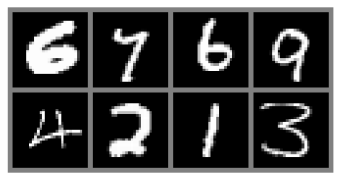

In [3]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

In [4]:
class MaskedConvolution(nn.Module):
    
    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        #Removed the dilation
        super().__init__()
        # For simplicity: calculate padding automatically 
        kernel_size = (mask.shape[0], mask.shape[1])
        padding = tuple([(kernel_size[i]-1)//2 for i in range(2)])
        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)
        # Mask as buffer => it is no parameter but still a tensor of the module 
        # (must be moved with the devices)
        self.register_buffer('mask', mask[None,None])
        
    def forward(self, x):
        self.conv.weight.data *= self.mask # Ensures zero's at masked positions
        return self.conv(x)

In [5]:
class VerticalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0
        
        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[kernel_size//2,:] = 0
        
        super().__init__(c_in, c_out, mask, **kwargs)

        
class HorizontalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0
        
        # For the very first convolution, we will also mask the center pixel
        if mask_center:
            mask[0,kernel_size//2] = 0
        
        super().__init__(c_in, c_out, mask, **kwargs)

In [6]:
inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

def show_center_recep_field(img, out):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients
    loss = out[0,:,img.shape[2]//2,img.shape[3]//2].sum() # L1 loss for simplicity
    loss.backward(retain_graph=True) # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    img_grads = img.grad.abs()
    img.grad.fill_(0) # Reset grads
    
    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0]) 
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

In [7]:
# Question 1
# Implement a version of the model without the gated convolution and dilation, using several layers of masked convolutions using vertical / horizontal stacks.

class PixelCNN2(pl.LightningModule):
    
    def __init__(self, c_in, c_hidden, layers, mask_starting_conv_center_pixel = True,  mask_other_conv_center_pixel = False):
        super().__init__()
        self.save_hyperparameters()
        
        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=mask_starting_conv_center_pixel, kernel_size=5)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=mask_starting_conv_center_pixel, kernel_size=5)

        # Masked Convolutions
        self.conv_vert = nn.ModuleList([VerticalStackConvolution(c_hidden, c_hidden, kernel_size=3, mask_center=mask_other_conv_center_pixel) for _ in range(layers)])
        self.conv_horiz = nn.ModuleList([HorizontalStackConvolution(c_hidden, c_hidden, kernel_size=3, mask_center=mask_other_conv_center_pixel) for _ in range(layers)])
        
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)
        
        
    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        self.to(x.device)
        x = (x.float() / 255.0) * 2 - 1 
        
        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)

        v_stack, h_stack = F.relu(v_stack), F.relu(h_stack)
        
        # Masked Convolutions
        for conv_v, conv_h in zip(self.conv_vert, self.conv_horiz):
            v_stack, h_stack = conv_v(v_stack), conv_h(h_stack)
            h_stack = h_stack + v_stack
            v_stack, h_stack = F.relu(v_stack), F.relu(h_stack)

        # 1x1 classification convolution
        out = self.conv_out(F.relu(h_stack))
        
        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1] // 256, out.shape[2], out.shape[3])
        return out
    

    def calc_loss(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='mean')
        return nll
        
    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill 
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:]) 
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        loss = self.calc_loss(batch[0])                             
        self.log('train_nll', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.calc_loss(batch[0])
        self.log('val_nll', loss)
    
    def test_step(self, batch, batch_idx):
        loss = self.calc_loss(batch[0])
        self.log('test_nll', loss)
    
        

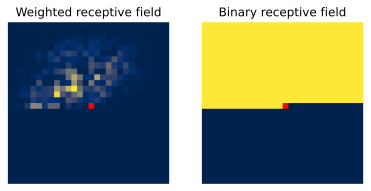

In [8]:
test_model = PixelCNN2(c_in=1, c_hidden=128, layers = 12, mask_starting_conv_center_pixel = True, mask_other_conv_center_pixel = False)
inp = torch.zeros(1,1,28,28)
inp.requires_grad_()
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

In [9]:
def train_model(use_pretrained = False, pretrained_path = "", **kwargs):
    logger = TensorBoardLogger("tb_logs", name="PixelCNN-ex4")
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "PixelCNN2"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         logger = logger,
                         max_epochs=150,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_nll"),
                                    LearningRateMonitor("epoch")])
    result = None
    
    # Check whether pretrained model exists. If yes, load it and skip training
    if os.path.isfile(pretrained_path) and use_pretrained:
        print("Found pretrained model, loading...")
        model = PixelCNN2.load_from_checkpoint(pretrained_path)
        ckpt = torch.load(pretrained_path, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = PixelCNN2(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)
    
    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

In [10]:
#All graphs taken from tensorboard

%load_ext tensorboard
%tensorboard --logdir tb_logs

In [11]:
# QUESTION 1 TRAIN
pretrained_path = "tb_logs//PixelCNN-ex4//q1//checkpoints//epoch=20-step=8190.ckpt"
model_q1, result = train_model(c_in=1, c_hidden=128, layers = 12, use_pretrained=True, pretrained_path=pretrained_path)
test_res = result["test"][0]
print("nll loss: %4.3f" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_nll"]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model, loading...


You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

nll loss: 0.654


Seed set to 10


  0%|          | 0/28 [00:00<?, ?it/s]

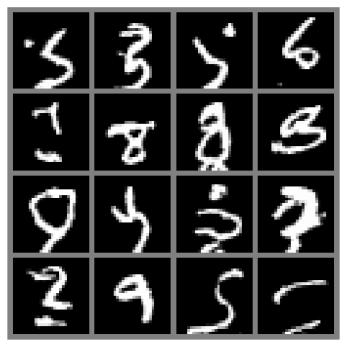

In [12]:
# SAMPLE FROM MODEL QUESTION 1
pl.seed_everything(10)
samples = model_q1.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

### Results
- **Training, Validation , Test Plots for negative log likelihoods:**
  <img src="https://raw.githubusercontent.com/daiyral/ex4/main/plots/q1/q1_train_plot.png" alt="Training Loss" width="1000"/>
  <img src="https://raw.githubusercontent.com/daiyral/ex4/main/plots/q1/q1_val_plot.png" alt="Validation Loss" width="1000"/>
  <img src="https://raw.githubusercontent.com/daiyral/ex4/main/plots/q1/q1_test_plot.png" alt="Test Loss" width="1000"/>

# Question 2

In [13]:
# QUESTION 2
# We set that the center pixel should not be masked. this means that pixel i depends on the input pixel i aswell.
# We get a loss value that is very low but the samples are all black pixels. 
# this is because generating only black pixels will produce a low loss, even when its not correct.
# We are performing an "illegal action" by not masking the center pixel. 
# since the center pixel is not masked, the model can generate the pixel value based on the pixel value itself.  but this pixel value is black since its not generated yet
pretrained_path = "tb_logs//PixelCNN-ex4//q2//checkpoints//epoch=20-step=8190.ckpt"
model_q2, result = train_model(c_in=1, c_hidden=128, layers = 12, mask_starting_conv_center_pixel = False, mask_other_conv_center_pixel = False, use_pretrained=True, pretrained_path=pretrained_path)
test_res = result["test"][0]
print("nll loss: %4.3f" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_nll"]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

nll loss: 0.117


Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

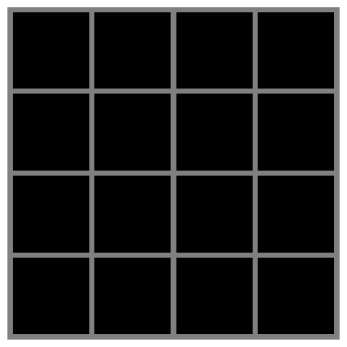

In [14]:
# SAMPLE FROM MODEL QUESTION 2
pl.seed_everything(1)
samples = model_q2.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

### Results
- **Training, Validation, Test Plots:**
<br/>
  <img src="https://raw.githubusercontent.com/daiyral/ex4/main/plots/q2/q2_train_plot.png" alt="Training Loss (Non-Causal)" width="1000"/>
  <img src="https://raw.githubusercontent.com/daiyral/ex4/main/plots/q2/q2_val_plot.png" alt="Validation Loss (Non-Causal)" width="1000"/>
  <img src="https://raw.githubusercontent.com/daiyral/ex4/main/plots/q2/q2_test_plot.png" alt="Test Loss (Non-Causal)" width="1000"/>

# Question 3

A) the marginal probability of the pixel at position (0,0) since the first pixel is not dependent on any other pixel the model directly outputs the first pixels marginal probability

In [15]:
def show(probs):
  plt.figure(figsize=(10, 6))
  plt.bar(np.arange(256), probs, width=0.8, align='center', color='blue', alpha=0.7)
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Probability')
  plt.yscale('log')
  plt.title('Histogram of Pixel Intensity Probabilities')
  plt.grid(True)
  plt.show()

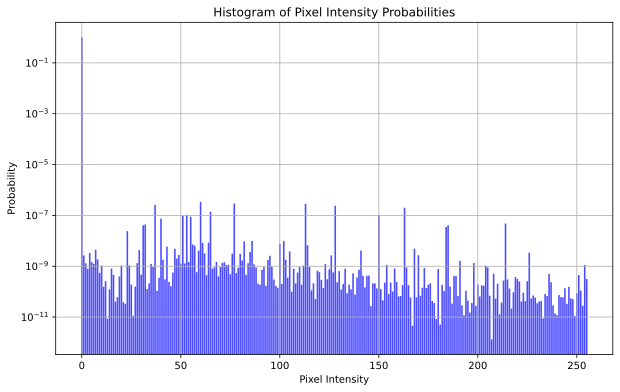

In [16]:
def part_a(pixel_pos):
  prediction = model_q1.forward(torch.zeros((1, 1, 28, 28))-1)
  probs = F.softmax(prediction[:,:,0, pixel_pos[0], pixel_pos[1]],dim=-1).detach().cpu().numpy().flatten()
  show(probs)

part_a((0,0))

B) The marginal probability of the pixel at position (14,14).
We cant compute it exactly however we can sample multiple images and look at the probability of the middle pixel from each sample and compute its mean. meaning we use the monte carlo method.

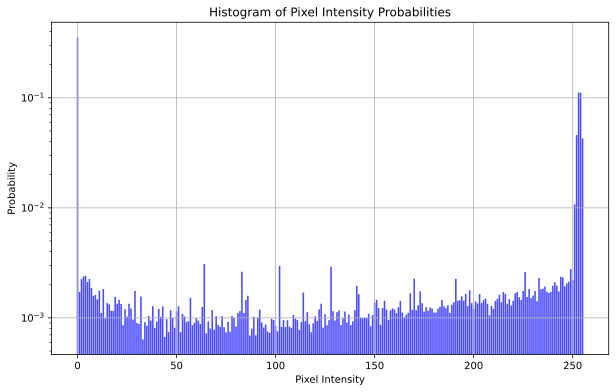

In [17]:
det_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, drop_last=False)
imgs,_ = next(iter(det_loader))
imgs = imgs.to(device)
with torch.no_grad():
    out = model_q1(imgs)
    out = out[:,:,:,14,14] # pixel at x,y
    out = F.softmax(out, dim=1)
    mean_out = out.mean(dim=[0]).cpu().numpy().flatten() # mean over batch
show(mean_out)


c) The conditional probability of the middle pixel, given the values of all pixels above and to the left of it.
The model directly outputs it since pixel 14,14 is conditioned on the above and left pixels.

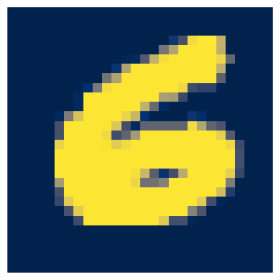

tensor(253)


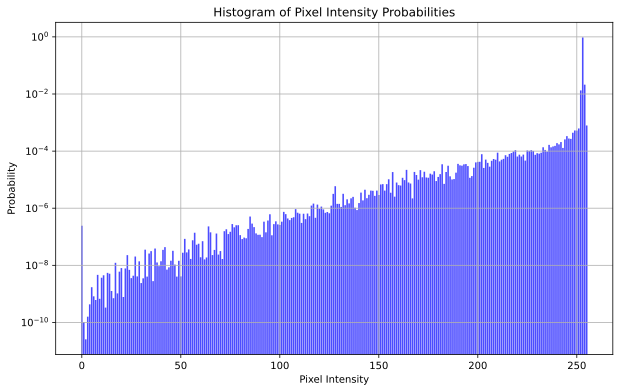

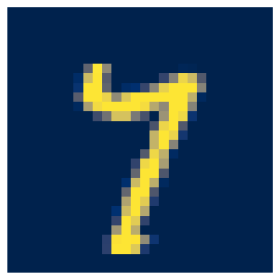

tensor(0)


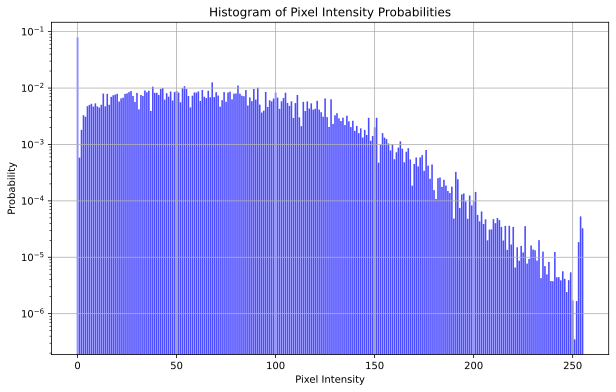

In [18]:

def part_c(pixel_pos, image):
  img_init = image.clone().to(device)
  img_init[:,15:,:] = -1 # complete bottom half of the image
  img_init[:, 14, 14:] = -1 # complete right half of the image
  img_init = img_init.unsqueeze(0)
  prediction = model_q1.forward(img_init)
  probs = F.softmax(prediction[:,:,0, pixel_pos[0], pixel_pos[1]],dim=-1).detach().cpu().numpy().flatten()
  show(probs)
for i in range(2):
  plt.imshow(train_set[i][0].squeeze(0))
  plt.axis('off')  # Hide axis labels and ticks
  plt.show()
  print(train_set[i][0].squeeze(0)[14,14])
  part_c((14,14), train_set[i][0])



d)The conditional probability of the middle pixel, given the values of all pixels below and to the right of it.


It is possible to use Gibbs by using section e(probability given all other pixels) we simply condition the input pixels below and to the right of the middle pixel and sample the pixels from the top half for many iterations. however it is very resource intensive.
Instead we can try to make this an optimization problem by using Variational inference.
The objective is to compute the conditional probability  p(x | y) where x is our middle pixel and y is the pixels below and to the right of it.
Since p(x,y) is simply our model output probability for all pixels.
We define set the lower bound (ELBO) on p(x) using the ELBO formula we saw in class. Then we try to optimize the paramater q that maximises the ELBO.
We can choose q as a gaussian distribution for example and once q is determined we can approximate p(x|y)


In [ ]:
# This is an example of how to perform the gibbs sampling. (dont run the code just an example)
def part_d(image, num_itr=10000):
  im = image.clone().to(device)
  im[:,:15,:] = 0 
  im[:, 14, :14] = 0 
  for _ in range(num_itr):
    num = torch.randint(0, 28*14+14, (1,))
    h = num//14
    w = num%14
    probs = part_e((h, w), im)
    im[:, h, w] = probs
  return im
for i in range(2):
  plt.axis('off')  # Hide axis labels and ticks
  plt.show()
  probs = part_d(train_set[i][0], 100000)
  print(probs)

e) The conditional probability of the middle pixel, given the values of all other pixels in the image.

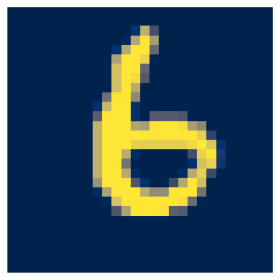

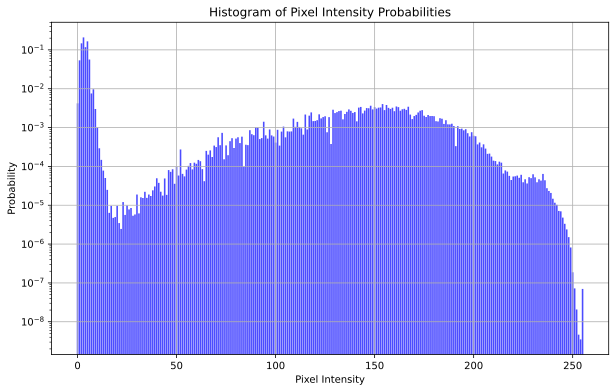

In [21]:
def part_e(im):
    im[:, 0, 14, 14] = torch.arange(0, 256)
    prediction = model_q1.forward(im)
    probs = F.softmax(prediction[:, :, 0, :, :], dim=-1).detach().cpu().numpy()
    final = np.zeros(256)
    img_np = im[:, 0, :, :].cpu().numpy().astype(int)
    h_indices, w_indices = np.indices((28, 28))
    final = [np.sum(np.log(probs[i, img_np[i, h_indices, w_indices], h_indices, w_indices])) for i in range(256)]
    final = np.exp(final - np.max(final))
    final /= np.sum(final)
    show(final)
plt.imshow(train_set[2][0].squeeze(0))
plt.axis('off') 
plt.show()
im = train_set[2][0].unsqueeze(0).clone()
im = im.repeat(256, 1, 1, 1)
part_e(im)


Original image and input image to sampling:


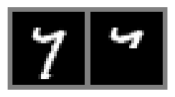

Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


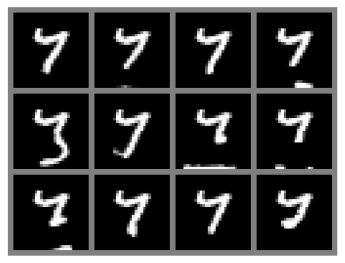

Original image and input image to sampling:


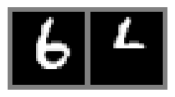

Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


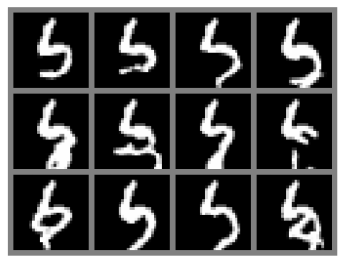

In [20]:
# f) Samples of the bottom half of an image, given the top half of an image.
def autocomplete_image(img):
    # Remove lower half of the image
    img_init = img.clone()
    img_init[:,14:,:] = -1
    print("Original image and input image to sampling:")
    show_imgs([img,img_init])
    # Generate 12 example completions
    img_init = img_init.unsqueeze(dim=0).expand(12,-1,-1,-1).to(device)
    pl.seed_everything(1)
    img_generated = model_q1.sample(img_init.shape, img_init.clone())
    print("Autocompletion samples:")
    show_imgs(img_generated)

for i in range(1,3):
    img = train_set[i][0]
    autocomplete_image(img)

g) Samples of the top half of an image, given the bottom half of an image.

Given section D, we can determine the conditional probability of the middle pixel based on the values of all the pixels located below and to the right of it.
We will systematically go through each pixel moving to the left and then upwards, calculate the value of the pixel in position i,j using section d and iterate
until we hit pixel 0,0.

In [ ]:
# g) Samples of the bottom half of an image, given the top half of an image. (dont run the code just an example)

def part_g(img):
    img_init = img.clone()
    img_init[:,:14,:] = -1
    show_imgs([img,img_init])
    # iterate over top half
    for h in range(13,-1,-1):
        for w in range(27,13,-1):
            img_init[:,h,w] = part_d(img_init[:,h,w])
    print("Autocompletion samples:")
    show_imgs(img_init)

img = train_set[0][0]
part_g(img)